In [ ]:
#Load source_5lang.txt and target_5lang.txt
#Load the file 'translator' to load trained weights

In [ ]:
!pip install tensorflow_text

In [ ]:
# Importing all required libraries.
import numpy as np
import typing
from typing import Any, Tuple
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
# Pulling data in from the source and target files.
# Encoding used "utf8".

with open("source_5lang.txt",'r',  encoding="utf8") as f:
    lines_inp = f.readlines()

with open("target_5lang.txt",'r',  encoding="utf8") as f:
    lines_targ = f.readlines()

In [ ]:
# Filtering out the number of lines to be taken as input.
inp = lines_inp[0:250000:1]
targ = lines_targ[0:250000:1]

In [ ]:
# Building numpy arrays with the imported data.

import numpy as np
inp = np.array(inp)
targ = np.array(targ)

print(len(inp))
print(len(targ))

250000
250000


In [ ]:
# Building a batch size of 128.
BUFFER_SIZE = len(inp)
BATCH_SIZE = 128

# Shuffle and generate datasets.
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
# Function to to text pre-processing.

def text_preprocessing(input_text):

# Normalizing
  input_text = tf_text.normalize_utf8(input_text, 'NFKD')

# Turning to lowercase
  input_text = tf.strings.lower(input_text)

# Removing and replacing specified characters for preproceesing.
  input_text = tf.strings.regex_replace(input_text, '[^ a-z.?!,¿]', '')
  input_text = tf.strings.regex_replace(input_text, '[.?!,¿]', r' \0 ')

# Removing spaces that are not required.
  input_text = tf.strings.strip(input_text)

# Adding [START] and [END] token infront of every sentence.
  input_text = tf.strings.join(['[START]', input_text, '[END]'], separator=' ')
  return input_text

In [ ]:
# Building input and target vocabs.

# Checking for Vocab size.
# Re-access generated vocab size after checking length of generated vocab.
max_vocab_size = 151760

In [ ]:
input_text_processor = preprocessing.TextVectorization(
    standardize=text_preprocessing, max_tokens=max_vocab_size)
input_text_processor.adapt(inp)

output_text_processor = preprocessing.TextVectorization(
    standardize=text_preprocessing,
    max_tokens=max_vocab_size)
output_text_processor.adapt(targ)

In [ ]:
input_vocab = np.array(input_text_processor.get_vocabulary())
output_vocab = np.array(output_text_processor.get_vocabulary())

In [ ]:
len(input_vocab)

61637

In [ ]:
len(output_vocab)

151760

In [ ]:
# Constants for the model.
# Chosen to nth power of 2.
# Generally chosen between 0-300.

embedding_dim = 256
units = 1024

In [ ]:
#Generating an Encoder class.

class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    vectors = self.embedding(tokens)
    output, state = self.gru(vectors, initial_state=state)
    return output, state

In [ ]:
#Generating Global Attention class.

class Global_Attention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()

    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)
    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    w1_query = self.W1(query)
    w2_key = self.W2(value)

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    return context_vector, attention_weights

In [ ]:
#Generating Decoder class.

class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim


    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    self.attention = Global_Attention(self.dec_units)

    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [ ]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [ ]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:

  vectors = self.embedding(inputs.new_tokens)
  rnn_output, state = self.gru(vectors, initial_state=state)
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
  attention_vector = self.Wc(context_and_rnn_output)
  logits = self.fc(attention_vector)

  return DecoderOutput(logits, attention_weights), state

In [ ]:
Decoder.call = call

In [ ]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [ ]:
# Defining a loss function.
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):

    loss = self.loss(y_true, y_pred)
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask

    return tf.reduce_sum(loss)

In [ ]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor,
               use_tf_function=True):

    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [ ]:
def _preprocess(self, input_text, target_text):
  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)

  # Convert IDs to masks.
  input_mask = input_tokens != 0

  target_mask = target_tokens != 0
  return input_tokens, input_mask, target_tokens, target_mask

In [ ]:
TrainTranslator._preprocess = _preprocess

In [ ]:
def _train_step(self, inputs):
  input_text, target_text = inputs

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    enc_output, enc_state = self.encoder(input_tokens)

    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  variables = self.trainable_variables
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  return {'batch_loss': average_loss}

In [ ]:
TrainTranslator._train_step = _train_step

In [ ]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)

  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [ ]:
TrainTranslator._loop_step = _loop_step

In [ ]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [ ]:
TrainTranslator._tf_train_step = _tf_train_step

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [ ]:
def tokens_to_text(self, result_tokens):
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  result_text = tf.strings.reduce_join(result_text_tokens, axis=1, separator=' ')

  result_text = tf.strings.strip(result_text)
  return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

In [ ]:
def sample(self, logits, temperature):
  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else:
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)

  return new_tokens

In [ ]:
Translator.sample = sample

In [ ]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    done = done | (new_tokens == self.end_token)
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_unrolled

In [ ]:
%%time
input_text = tf.constant([
    #"Hace mucho frío aquí.",
    "It's really cold here.",
    #"Tratar de descubrir.",
    "Try to find out.",

])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
#@title
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)

  enc_output, enc_state = self.encoder(input_tokens)

  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])

  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = attention.stack()

    attention_stack = tf.squeeze(attention_stack, 2)

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_symbolic

In [ ]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

### Visualize the process

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  sentence = text_preprocessing(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='inferno', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

In [ ]:
%%time
input_text = tf.constant([
    'This is my life.',
    #'Esta es mi vida.',
    'Are they still home?',
    #'¿Todavía están en casa?',
    'Try to find out.',
    #'Tratar de descubrir.',
])

result = translator.tf_translate(input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

In [ ]:
#tf.saved_model.save(translator, 'translator',
#                    signatures={'serving_default': translator.tf_translate})

In [ ]:
#Loading a saved model weights.

# Loading a saved model
Upload the .txt files
, Upload the saved model in translator folder



In [ ]:
reloaded_translator = tf.saved_model.load("translator")

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  sentence = text_preprocessing(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='inferno', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

In [ ]:
# Function to to text pre-processing.

def text_preprocessing(input_text):

# Normalizing
  input_text = tf_text.normalize_utf8(input_text, 'NFKD')

# Turning to lowercase
  input_text = tf.strings.lower(input_text)

# Removing and replacing specified characters for preproceesing.
  input_text = tf.strings.regex_replace(input_text, '[^ a-z.?!,¿]', '')
  input_text = tf.strings.regex_replace(input_text, '[.?!,¿]', r' \0 ')

# Removing spaces that are not required.
  input_text = tf.strings.strip(input_text)

# Adding [START] and [END] token infront of every sentence.
  input_text = tf.strings.join(['[START]', input_text, '[END]'], separator=' ')
  return input_text

In [ ]:
%%time
input_text = tf.constant([
    '<2es> This is my life.',
    #'Esta es mi vida.'
])

result = reloaded_translator.tf_translate(input_text)

for tr in result['text']:
  print(tr.numpy().decode())
  translated = tr.numpy().decode()

esta es su vida .
Wall time: 537 ms


In [ ]:
from nltk.translate import bleu
from nltk.translate.bleu_score import SmoothingFunction
SF = SmoothingFunction()
ref = translated.split()
hyp = 'Esta es mi vida.'.split()
bleu([ref], hyp, smoothing_function=SF.method1)

0.06257106818159155

In [ ]:
%%time
input_text = tf.constant([
    '<2es> It is my life.',
    #'Es mi vida.',
    '<2pt> It is now or never.',
    #'E agora, ou nunca.',
    '<2it> I just want to live forever.',
    #'Voglio solo vivere per sempre.',
    '<2tr> My heart is like an open highway.',
    #'Kalbim acik otoban gibi.'
    '<2fr> I am not going to live forever.'
    #'Je ne vais pas vivre eternellement.'
])

Wall time: 0 ns


In [ ]:
result = reloaded_translator.tf_translate(input_text)
for tr in result['text']:
  print(tr.numpy().decode())

es un vida
e igual que nunca .
voglio solo davvero per cui i single .
yazk de bir durum once .
j . e moi de pour commencer .


In [ ]:
def calculate_BLEU_score(original_sentence, translate_sentence):
    input_text = tf.constant([
        original_sentence,
    ])

    result = reloaded_translator.tf_translate(input_text)

    predicted = ''
    for tr in result['text']:
        predicted = predicted + tr.numpy().decode()
        translated = tr.numpy().decode()

    ref = translated.split()
    hyp = translate_sentence.split()
    print("Original Sentence : ", original_sentence)
    print("Expected Sentence : ", translate_sentence)
    print("Predicted Sentence: ", predicted)

    print("Blue Score        : ", bleu([ref], hyp))
    print()

In [ ]:
originial_sentence = []
translate_sentence = []

originial_sentence.append('<2es> it is my life.')
translate_sentence.append('es mi vida .')

originial_sentence.append('<2pt> it is now or never.')
translate_sentence.append('e agora , ou nunca .')

originial_sentence.append('<2it> i just want to live forever.')
translate_sentence.append('voglio solo vivere per sempre .')

originial_sentence.append('<2tr> my heart is like an open highway.')
translate_sentence.append('kalbim acik otoban gibi .')

originial_sentence.append('<2fr> i am not going to live forever.')
translate_sentence.append('je ne vais pas vivre eternellement .')

In [ ]:
for i in range(len(originial_sentence)):
    calculate_BLEU_score(originial_sentence[i], translate_sentence[i])

Original Sentence :  <2es> it is my life.
Expected Sentence :  es mi vida .
Predicted Sentence:  es mi vida .
Blue Score        :  1.0

Original Sentence :  <2pt> it is now or never.
Expected Sentence :  e agora , ou nunca .
Predicted Sentence:  agora nao esta e nunca .
Blue Score        :  9.013778876140909e-155

Original Sentence :  <2it> i just want to live forever.
Expected Sentence :  voglio solo vivere per sempre .
Predicted Sentence:  vorrei farla nascondere .
Blue Score        :  1.1640469867513693e-231

Original Sentence :  <2tr> my heart is like an open highway.
Expected Sentence :  kalbim acik otoban gibi .
Predicted Sentence:  benim de basma davet ediyor , bence .
Blue Score        :  6.686350417856737e-232

Original Sentence :  <2fr> i am not going to live forever.
Expected Sentence :  je ne vais pas vivre eternellement .
Predicted Sentence:  a je suis continuer a son corps .
Blue Score        :  1.154647032204335e-231



<ipython-input-22-b756d720df36>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-22-b756d720df36>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


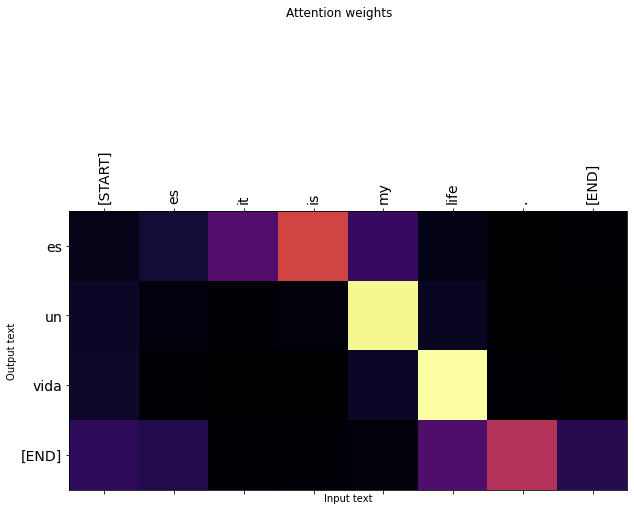

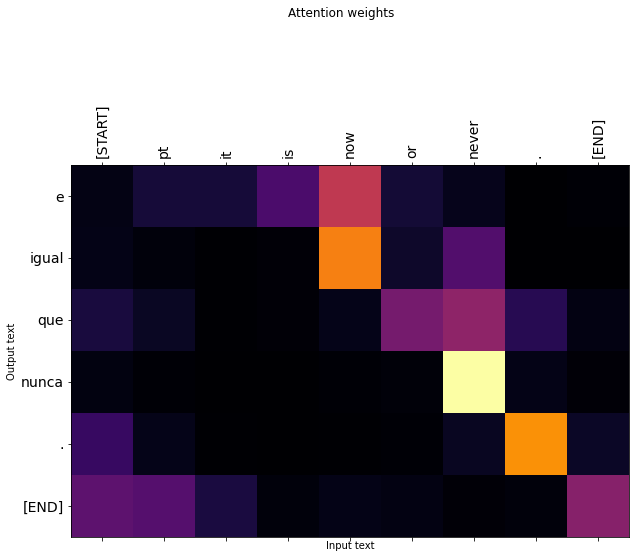

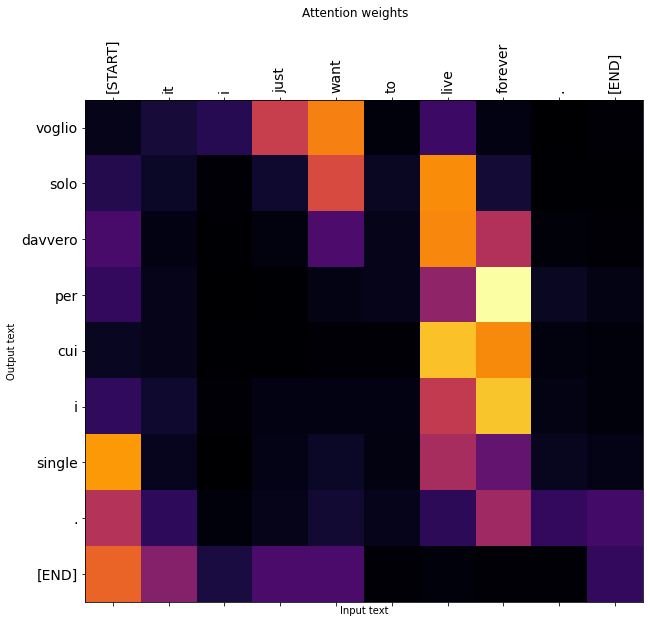

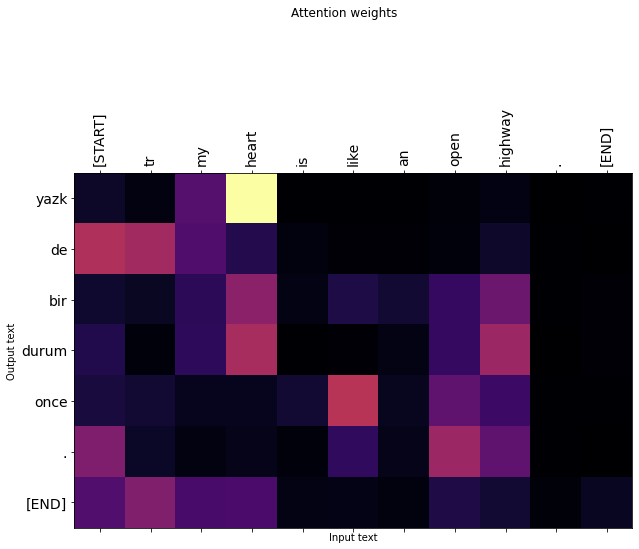

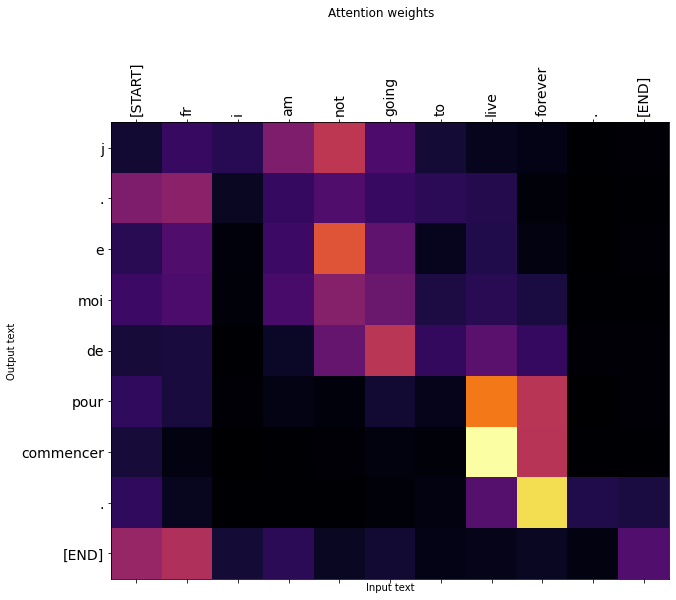

In [ ]:
for i in range(len(originial_sentence)):
    plot_attention(result['attention'][i], originial_sentence[i], result['text'][i])